## Problem Statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from glob import glob
import matplotlib.pyplot as plt

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size=32,
            image_size=(180, 180),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='training',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False,
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size=32,
            image_size=(180, 180),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='validation',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False,
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
len(train_ds)

56

In [8]:
len(val_ds)

14

In [9]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
len(class_names)

9

### Visualize the data


<Figure size 720x720 with 0 Axes>

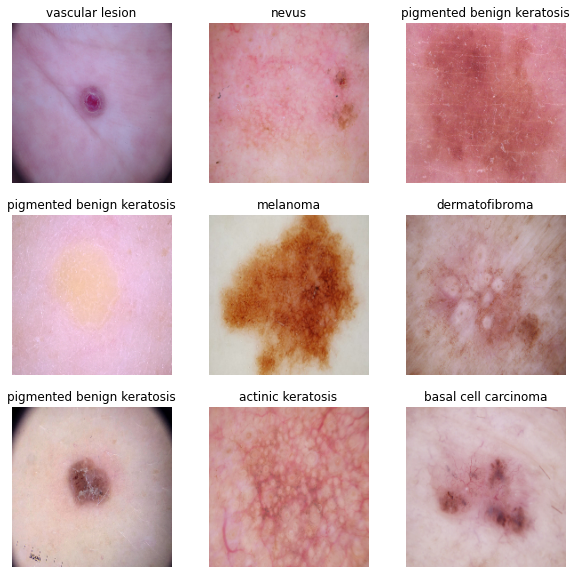

In [11]:
plt.figure(figsize=(10,10))
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1

In [14]:
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    # layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    # layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    # layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Conv2D(128,3,padding="same",activation="relu"),
    # layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation="relu"),
    # layers.BatchNormalization(),
    layers.Dense(len(class_names),activation="softmax")
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0

### Compiling the model

In [16]:
INIT_LR = 1e-4
epochs = 20
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)

C:\Users\Abhilash Shah\anaconda3\envs\base_tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:

model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Training Model

In [18]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 46ms/step - loss: 1.9920 - accuracy: 0.2528 - val_loss: 2.0500 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.7881 - accuracy: 0.3510 - val_loss: 1.9405 - val_accuracy: 0.3602
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.6845 - accuracy: 0.3862 - val_loss: 1.8625 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5712 - accuracy: 0.4330 - val_loss: 1.7848 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4985 - accuracy: 0.4782 - val_loss: 1.7488 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4392 - accuracy: 0.5045 - val_loss: 1.7049 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4153 - accuracy: 0.5190 - val_loss: 1.6745 - val_accuracy: 0.4966
Epoch 8/20
56

### Visualizing training results

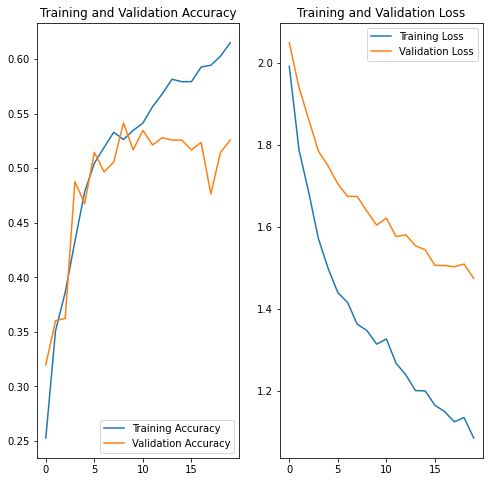

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model train and test accuracy

In [20]:
_, train_acc = model.evaluate(train_ds, verbose=0)
_, test_acc = model.evaluate(val_ds, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.596, Test: 0.526


### Findings 

- Model trained on the given dataset seems to be overfitting as we can see from the plot that there is a huge gap between training loss and validation loss

### Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        layers.experimental.preprocessing.RandomZoom(.3,.2),
        layers.experimental.preprocessing.RandomRotation(.2)
    ]
)

<Figure size 720x720 with 0 Axes>

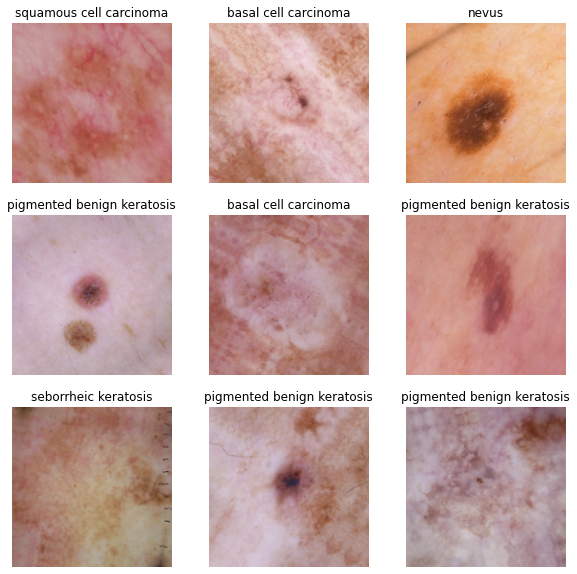

In [22]:
plt.figure(figsize=(10,10))
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(images[i].numpy().astype("uint8")))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Model 2

In [23]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    # layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    # layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    # layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Conv2D(128,3,padding="same",activation="relu"),
    # layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Dense(len(class_names),activation="softmax")
])

### Compiling the Model

In [24]:
INIT_LR = 1e-4
epochs = 20
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)

In [25]:
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Training Model

In [26]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 36ms/step - loss: 2.2378 - accuracy: 0.1864 - val_loss: 2.1231 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 2.0564 - accuracy: 0.2645 - val_loss: 2.0606 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.9360 - accuracy: 0.3175 - val_loss: 2.0528 - val_accuracy: 0.1790
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 1.8347 - accuracy: 0.3488 - val_loss: 2.0359 - val_accuracy: 0.1790
Epoch 5/20
56/56 [==============================] - 2s 33ms/step - loss: 1.7649 - accuracy: 0.3717 - val_loss: 2.0089 - val_accuracy: 0.1879
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6897 - accuracy: 0.4269 - val_loss: 1.9601 - val_accuracy: 0.1879
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6425 - accuracy: 0.4637 - val_loss: 1.9336 - val_accuracy: 0.2260
Epoch 8/20
56

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (180, 180, 3)             0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
dropout_4 (Dropout)          (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
dropout_5 (Dropout)          (None, 90, 90, 32)       

### Visualizing training results

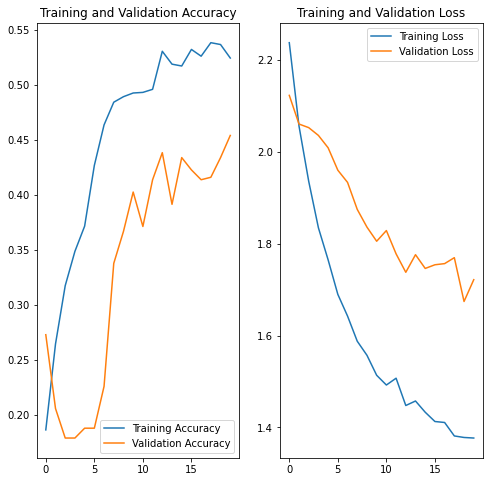

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model train and test accuracy

In [29]:
_, train_acc = model.evaluate(train_ds, verbose=0)
_, test_acc = model.evaluate(val_ds, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.429, Test: 0.454


### Findings 

- After adding augmentation layer the model overfitting issue seems to be handled somewhat but the as we can see from the plot the accuracy is very low and it is a problem of underfitting

### Class Imbalance problem 

As we can see there is class imbalance i.e. some classes have fewer images than others
For example the class `dermatofibroma` has the least number of samples whereas the class `melanoma` has the highest number of samples and the difference is in hundreds of images

<Figure size 720x720 with 0 Axes>

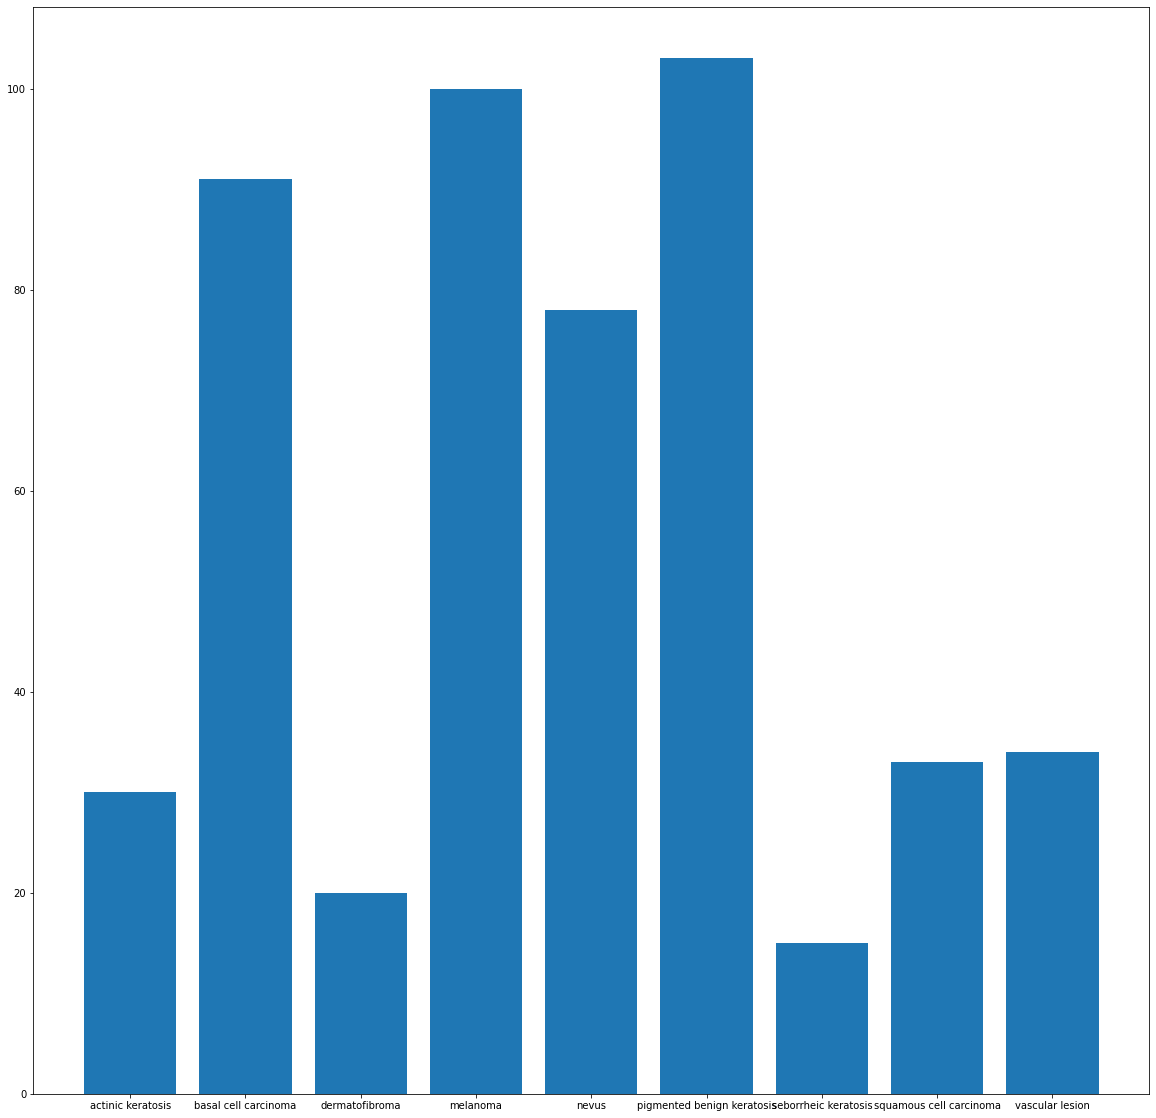

In [30]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

### Image Augmentation [External]

To handle class imabalance, augmentor library is used add 500 samples in each of the class

In [31]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.flip_left_right(probability=0.4)

# Now we add a vertical flip operation to the pipeline:
    p.flip_top_bottom(probability=0.8)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14DCE324C10>: 100%|██████████| 500/500 [00:01<00:00, 282.64 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14DCE4CDDF0>: 100%|██████████| 500/500 [00:01<00:00, 269.69 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14DCE55C5B0>: 100%|██████████| 500/500 [00:01<00:00, 278.09 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x14DCE4B40D0>: 100%|██████████| 500/500 [00:10<00:00, 46.97 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x14DCE343640>: 100%|██████████| 500/500 [00:08<00:00, 58.30 Samples/s]                 


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14DCE4DB130>: 100%|██████████| 500/500 [00:02<00:00, 234.52 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x14F2CECB5B0>: 100%|██████████| 500/500 [00:04<00:00, 114.92 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14DCE793940>: 100%|██████████| 500/500 [00:01<00:00, 256.28 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14F2CEB80D0>: 100%|██████████| 500/500 [00:02<00:00, 243.55 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
new_path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# new_path_list

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [35]:
dataframe_dict_new = dict(zip(new_path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [37]:
df2.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


#### Training set

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size=32,
            image_size=(180, 180),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='training',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False,
            )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Validation set

In [39]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size=32,
            image_size=(180, 180),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='validation',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False,
            )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<Figure size 720x720 with 0 Axes>

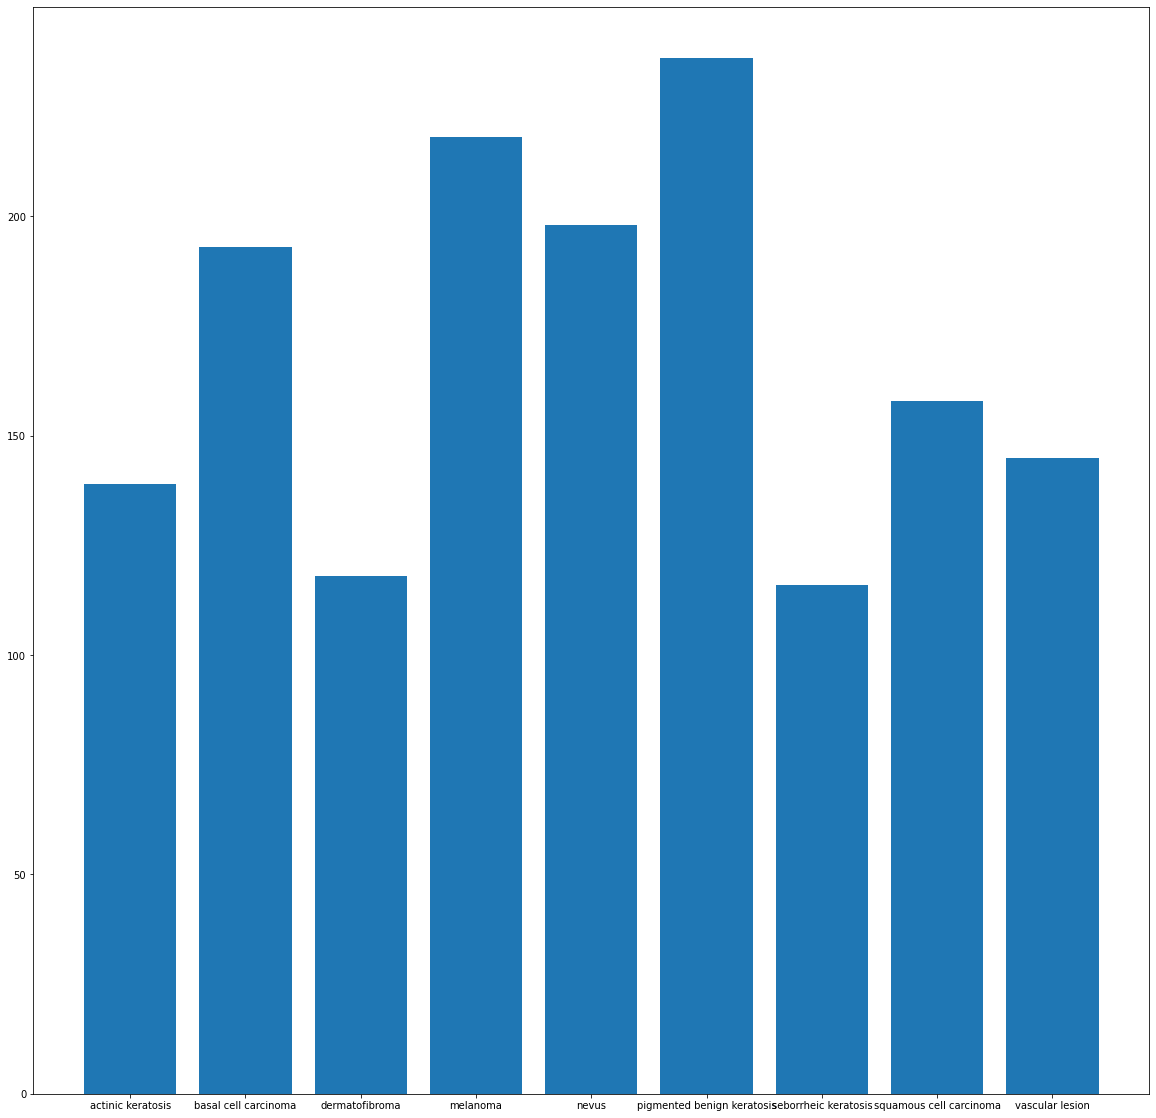

In [40]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

### Data Visualization

<Figure size 720x720 with 0 Axes>

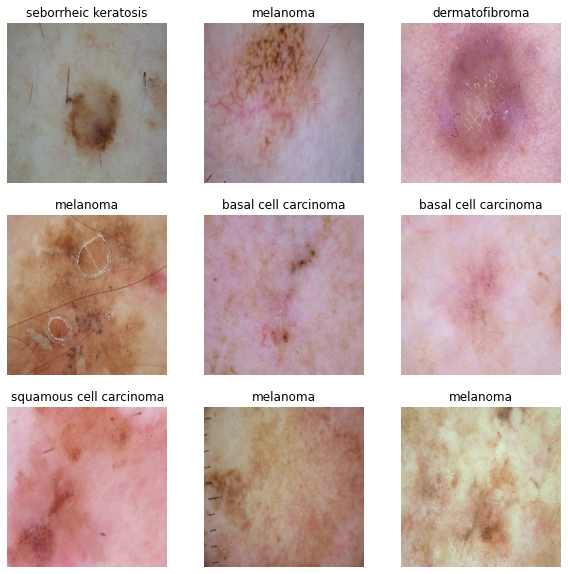

In [41]:
plt.figure(figsize=(10,10))
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [42]:
len(train_ds)

169

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 3

In [44]:
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    # layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    # layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    # layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Conv2D(128,3,padding="same",activation="relu"),
    # layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation="relu"),
    # layers.BatchNormalization(),
    layers.Dense(len(class_names),activation="softmax")
])

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
dropout_9 (Dropout)          (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
dropout_10 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 32)       

In [46]:
INIT_LR = 1e-4
epochs = 30
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)

C:\Users\Abhilash Shah\anaconda3\envs\base_tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [47]:
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [48]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 10s 28ms/step - loss: 1.9935 - accuracy: 0.2424 - val_loss: 1.9616 - val_accuracy: 0.2918
Epoch 2/30
169/169 [==============================] - 3s 17ms/step - loss: 1.7263 - accuracy: 0.3403 - val_loss: 1.8717 - val_accuracy: 0.3281
Epoch 3/30
169/169 [==============================] - 3s 17ms/step - loss: 1.6131 - accuracy: 0.3891 - val_loss: 1.7787 - val_accuracy: 0.4291
Epoch 4/30
169/169 [==============================] - 3s 17ms/step - loss: 1.5193 - accuracy: 0.4382 - val_loss: 1.7216 - val_accuracy: 0.3808
Epoch 5/30
169/169 [==============================] - ETA: 0s - loss: 1.4482 - accuracy: 0.45 - 3s 17ms/step - loss: 1.4482 - accuracy: 0.4560 - val_loss: 1.6853 - val_accuracy: 0.3890
Epoch 6/30
169/169 [==============================] - 3s 17ms/step - loss: 1.4209 - accuracy: 0.4649 - val_loss: 1.6394 - val_accuracy: 0.4410
Epoch 7/30
169/169 [==============================] - 3s 17ms/step - loss: 1.3575 - accuracy: 0.488

### Visualizing training results

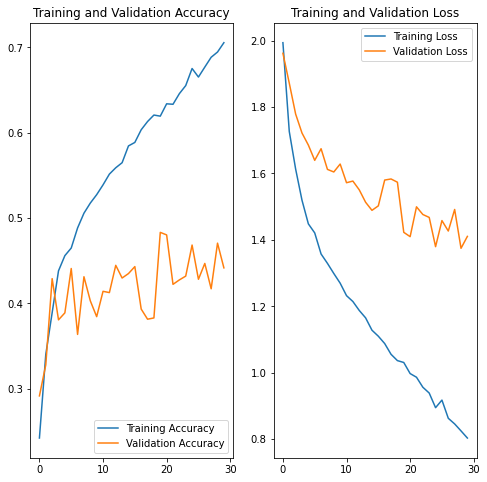

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model train and test accuracy

In [50]:
_, train_acc = model.evaluate(train_ds, verbose=0)
_, test_acc = model.evaluate(val_ds, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.497, Test: 0.442
